<a href="https://colab.research.google.com/github/captainsesman/RNA_CANCER_PROJECT/blob/main/RSNA_Cancer_Detection_Working_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.models import Sequential, Model
from keras.regularizers import l1_l2
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc,precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix
import shutil
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to your zip dataset file in your Google Drive
zip_dataset_path = '/content/drive/MyDrive/rsnacancer.zip'

# Set the destination folder in Colab to extract the contents of the zip file
destination_folder = '/content/dataset/'

# Extract the zip file to the destination folder
shutil.unpack_archive(zip_dataset_path, destination_folder)

In [ ]:
# Process and save images for each split
save_folder = "/content/dataset/"
train_output_dir = save_folder + "train_images"
val_output_dir =save_folder + "validation_images"
test_output_dir = save_folder + "test_images"
size = 256

In [ ]:
img_size = (size, size)
batch_size=32

In [28]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    train_output_dir,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)
val_gen = tf.keras.utils.image_dataset_from_directory(
   val_output_dir,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

Found 1620 files belonging to 2 classes.
Found 232 files belonging to 2 classes.


In [33]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

In [35]:
train_gen_norm = train_gen.map(lambda x, y: (normalization_layer(x), y))
val_gen_norm = val_gen.map(lambda x, y: (normalization_layer(x), y))

In [39]:
image_batch, labels_batch = next(iter(train_gen_norm))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.71470594


In [75]:

train_ds = train_gen_norm.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_gen_norm.cache().prefetch(buffer_size=AUTOTUNE)

In [51]:
input_shape = sample_batch[0].shape[1:]

In [52]:
input_shape

TensorShape([256, 256, 1])

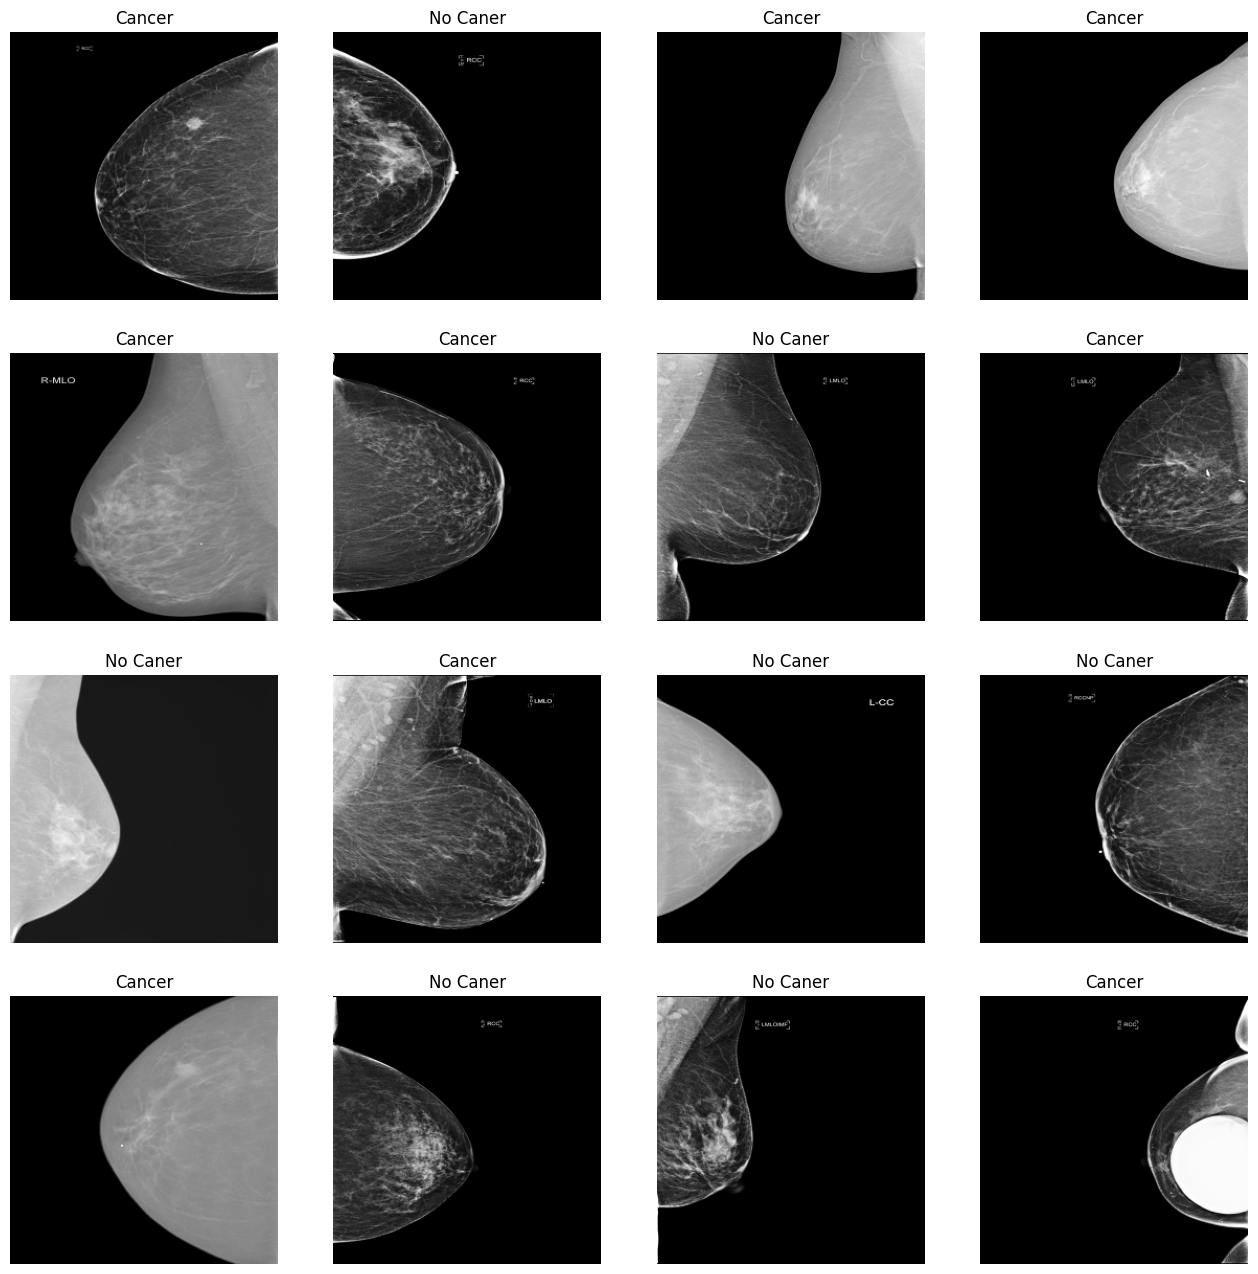

In [49]:
t_x, t_y = next(iter(train_gen))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1:
        c_ax.set_title('Cancer')
    else:
        c_ax.set_title('No Caner')
    c_ax.axis('off')

In [76]:

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path,
                             monitor= 'val_loss',
                             verbose=1,
                           save_best_only=True,
                              mode= min,
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss',
                       mode= min,
                       patience=10)
callbacks_list = [checkpoint, early]

In [77]:
valX, valY = next(iter(val_ds))

In [79]:
input_image = Input(shape=input_shape)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(input_image)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_image, outputs=output)

In [80]:

# Compile the model
optimizer = Adam(1e-5)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
weight_path="{}_my_model.best.hdf5".format('rsna_cancer')

checkpoint = ModelCheckpoint(weight_path,
                             monitor= 'val_loss',
                             verbose=1,
                           save_best_only=True,
                              mode= min,
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss',
                       mode= min,
                       patience=10)
callbacks_list = [checkpoint, early]

In [83]:
# Train the model using your data generators
history = model.fit(
    train_ds,
    steps_per_epoch=len(train_ds),
    epochs=100,
    validation_data=val_ds,
    validation_steps=len(val_ds),
    callbacks = callbacks_list
)

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5117
Epoch 1: val_loss improved from inf to 0.69238, saving model to rsna_cancer_my_model.best.hdf5
51/51 [==============================] - 9s 157ms/step - loss: 0.6930 - accuracy: 0.5117 - val_loss: 0.6924 - val_accuracy: 0.5647
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5407
Epoch 2: val_loss improved from 0.69238 to 0.69113, saving model to rsna_cancer_my_model.best.hdf5
51/51 [==============================] - 7s 132ms/step - loss: 0.6921 - accuracy: 0.5407 - val_loss: 0.6911 - val_accuracy: 0.5862
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5481
Epoch 3: val_loss improved from 0.69113 to 0.69048, saving model to rsna_cancer_my_model.best.hdf5
51/51 [==============================] - 7s 134ms/step - loss: 0.6912 - accuracy: 0.5481 - val_loss: 0.6905 - val_accuracy: 0.5819
Epoch 4/100
51/51 [==========

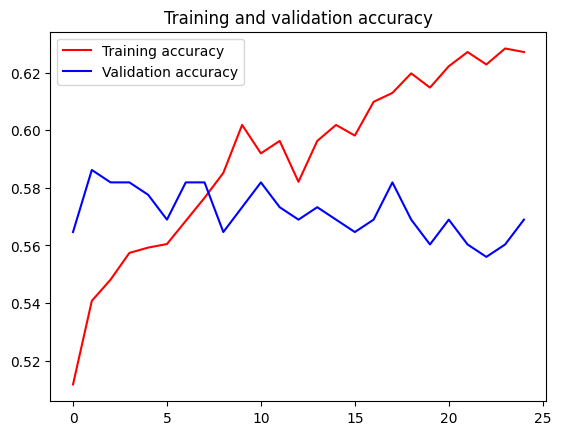

<Figure size 640x480 with 0 Axes>

In [84]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

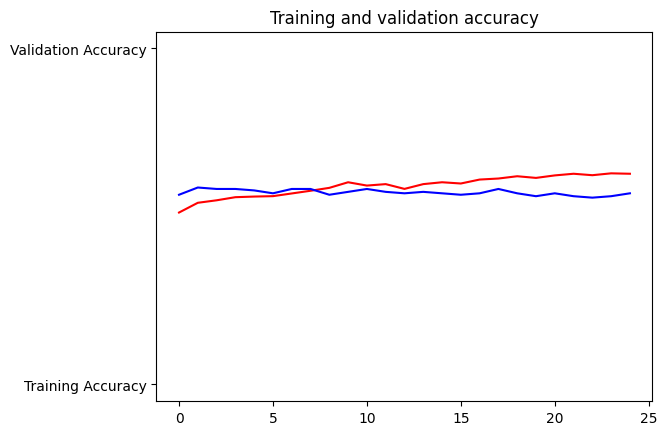

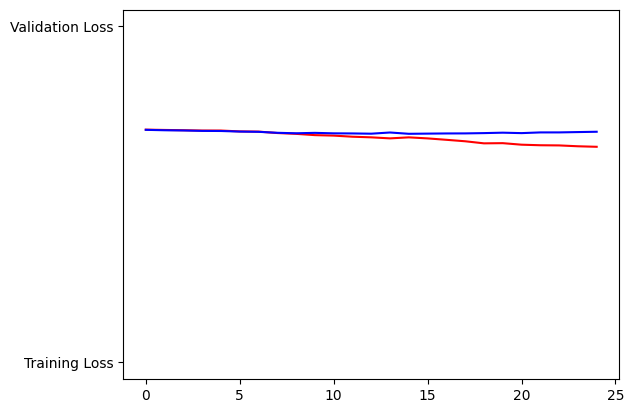

In [86]:
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [87]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists,
## so there is no need to make the model perfect.
model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1/1 [==============================] - 0s 122ms/step


In [88]:
def plot_auc(t_y, p_y):

    ## Hint: can use scikit-learn's built in functions here like roc_curve

    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    auc_k = auc(fpr, tpr)

    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)

    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


## what other performance statistics do you want to include here besides AUC?

# Todo
def  plt_confusion_matrix(t_y, p_y):
    sns.heatmap(confusion_matrix(t_y,p_y),annot=True)



def plot_history(history):

    bin_acc = history.history['binary_accuracy']
    val_bin_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize = (9, 9))

    ax1.plot(bin_acc, 'b', label='Training Accuracy')
    ax1.plot(val_bin_acc, 'g', label='Validation Accuracy')
    ax1.set_title('Training and validation accuracy')
    ax1.legend()

    ax2.plot(loss, 'g', label='Training loss')
    ax2.plot(val_loss, 'b', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.legend()


KeyError: ignored

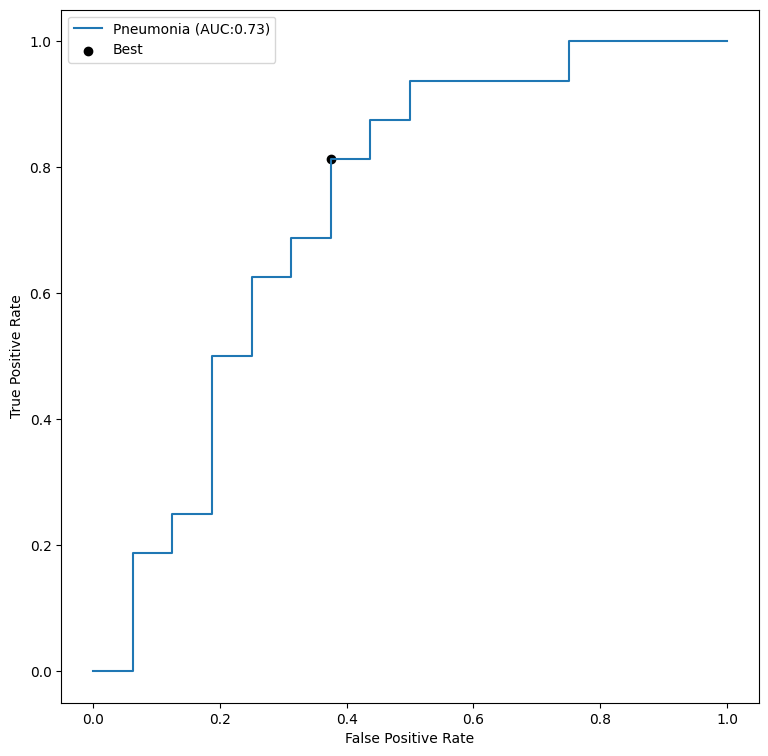

In [89]:
## plot figures

# Todo
plot_auc(valY,pred_Y)
plot_history(history)